In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.cluster import SpectralCoclustering
# is this a bad way of doing it
from sklearn import metrics

* count_matrix_org : original count matrix from GEO
* final_sample_info : final sample info file from GEO
* cm_data_incl_lq : data only version of count matrix (additional info of gene names and types removed)
    * transposed so that each row is a cell
    * still includes low quality sequences
* cm_data : cm_data_incl_lq with the low quality reads removed (so 515 rows)
* final_sample_info_sc : single cell records from final sample info file ("type" == "SC")
    * matches expected number of single cells (including tumour and non-tumour): 515
* cm_tumour : cm_data with only tumour cells selected (317 rows)


In [2]:
# read in raw data from GEO
# Count Matrix ORiGinal
count_matrix_org = pd.read_csv("../../data/breast-cancer-GSE75688/GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt", delimiter="\t", index_col=0)

# read in sample information from GEO
# excludes low quality reads but includes pooled samples
final_sample_info = pd.read_csv("../../data/breast-cancer-GSE75688/GSE75688_final_sample_information_GEO.txt", delimiter="\t")

In [3]:
final_sample_info

,sample,type,index,index2,index3
0,BC01_02,SC,Tumor,Tumor,Tumor
1,BC01_03,SC,Tumor,Tumor,Tumor
2,BC01_04,SC,Tumor,Tumor,Tumor
3,BC01_05,SC,Tumor,Tumor,Tumor
4,BC01_06,SC,Tumor,Tumor,Tumor
...,...,...,...,...,...
523,BC06_58,SC,nonTumor,Immune,Bcell
524,BC06_60,SC,Tumor,Tumor,Tumor
525,BC06_61,SC,nonTumor,Immune,Bcell
526,BC06_74,SC,Tumor,Tumor,Tumor


In [4]:
tumor_idexes = []
for i, index in enumerate(final_sample_info["index"]):
    #print(f"i = {i}, index = {index}")
    if index == "Tumor":
        tumor_idexes.append(i)

print(tumor_idexes)
print(pd.unique(final_sample_info["index"].loc[tumor_idexes]))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 63, 64, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 78, 79, 82, 84, 86, 87, 89, 90, 92, 93, 95, 96, 97, 98, 99, 101, 107, 109, 113, 114, 115, 118, 119, 120, 121, 125, 126, 130, 134, 136, 137, 142, 143, 145, 146, 147, 148, 149, 150, 151, 152, 153, 156, 157, 160, 162, 168, 169, 170, 172, 175, 178, 180, 185, 186, 187, 188, 189, 190, 191, 192, 193, 196, 198, 199, 200, 201, 202, 216, 219, 226, 229, 230, 233, 237, 242, 249, 251, 266, 270, 273, 274, 276, 277, 278, 280, 281, 282, 283, 285, 286, 287, 288, 291, 292, 293, 351, 352, 355, 356, 357, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 40

In [5]:
count_matrix_org

,gene_name,gene_type,BC01_Pooled,BC01_Tumor,BC02_Pooled,BC03_Pooled,BC03LN_Pooled,BC04_Pooled,BC05_Pooled,BC06_Pooled,...,BC11_04,BC11_07,BC11_28,BC11_43,BC11_56,BC11_69,BC11_70,BC11_78,BC11_81,BC11_88
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.10,TSPAN6,protein_coding,2.33,1.25,43.96,7.64,9.32,133.37,84.77,48.01,...,0.00,47.44,16.11,0.00,6.56,0.00,0.00,0.00,200.82,0.00
ENSG00000000005.5,TNMD,protein_coding,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ENSG00000000419.8,DPM1,protein_coding,60.70,28.44,74.73,41.41,87.69,120.41,70.67,92.23,...,198.96,0.00,0.00,20.63,0.00,0.00,0.00,136.07,22.03,204.58
ENSG00000000457.9,SCYL3,protein_coding,47.93,4.43,9.89,7.61,7.32,12.42,12.02,7.99,...,0.00,10.96,0.00,0.00,0.00,0.27,0.00,0.07,0.19,9.52
ENSG00000000460.12,C1orf112,protein_coding,4.79,1.67,10.87,0.92,15.13,17.10,5.69,29.20,...,0.00,6.97,9.02,0.00,0.00,0.14,247.69,22.60,11.35,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERCC-00170,ERCC-00170,ERCC,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ERCC-00171,ERCC-00171,ERCC,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SPIKE1,EC2,SPIKE_IN,14940.70,45728.19,10442.91,94250.71,40823.13,24540.58,12613.85,12759.76,...,166346.51,54443.35,120842.89,135291.06,138048.60,58840.26,65246.34,33465.11,108901.35,57492.01


In [6]:
#print(count_matrix_org.transpose())
count_matrix_org_t = count_matrix_org.transpose()

In [7]:
# count matrix, data only, BEFORE removal of low quality sequences
cm_data_incl_lq = count_matrix_org_t.iloc[2:,:]
cm_data_incl_lq

gene_id,ENSG00000000003.10,ENSG00000000005.5,ENSG00000000419.8,ENSG00000000457.9,ENSG00000000460.12,ENSG00000000938.8,ENSG00000000971.11,ENSG00000001036.9,ENSG00000001084.6,ENSG00000001167.10,...,ERCC-00162,ERCC-00163,ERCC-00164,ERCC-00165,ERCC-00168,ERCC-00170,ERCC-00171,SPIKE1,SPIKE2,SPIKE3
BC01_Pooled,2.33,0.0,60.7,47.93,4.79,0.0,0.06,46.54,11.61,9.51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14940.7,985.82,0.0
BC01_Tumor,1.25,0.0,28.44,4.43,1.67,0.0,9.64,20.97,5.97,4.81,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45728.19,607.5,0.0
BC02_Pooled,43.96,0.0,74.73,9.89,10.87,0.52,0.0,46.3,8.72,19.39,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10442.91,362.55,0.0
BC03_Pooled,7.64,0.0,41.41,7.61,0.92,0.0,0.0,8.57,5.51,0.28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94250.71,2949.35,0.0
BC03LN_Pooled,9.32,0.0,87.69,7.32,15.13,1.39,0.0,5.72,10.0,27.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40823.13,1291.13,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BC11_69,0.0,0.0,0.0,0.27,0.14,0.0,0.0,7.06,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58840.26,2286.91,0.0
BC11_70,0.0,0.0,0.0,0.0,247.69,0.0,0.81,4.49,0.0,53.21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65246.34,2821.49,0.0
BC11_78,0.0,0.0,136.07,0.07,22.6,0.0,0.83,0.82,70.26,0.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33465.11,1652.19,0.0
BC11_81,200.82,0.0,22.03,0.19,11.35,0.0,0.0,4.32,1.12,6.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,108901.35,3439.53,0.0


In [8]:
final_sample_info

,sample,type,index,index2,index3
0,BC01_02,SC,Tumor,Tumor,Tumor
1,BC01_03,SC,Tumor,Tumor,Tumor
2,BC01_04,SC,Tumor,Tumor,Tumor
3,BC01_05,SC,Tumor,Tumor,Tumor
4,BC01_06,SC,Tumor,Tumor,Tumor
...,...,...,...,...,...
523,BC06_58,SC,nonTumor,Immune,Bcell
524,BC06_60,SC,Tumor,Tumor,Tumor
525,BC06_61,SC,nonTumor,Immune,Bcell
526,BC06_74,SC,Tumor,Tumor,Tumor


In [9]:
final_sample_info_sc = final_sample_info[final_sample_info["type"] == "SC"]

In [10]:
cm_data = cm_data_incl_lq.loc[final_sample_info_sc["sample"]]
cm_data.shape

(515, 57915)

In [11]:
cm_tumour = cm_data.loc[final_sample_info_sc[final_sample_info_sc["index"] == "Tumor"]["sample"]]
cm_tumour

gene_id,ENSG00000000003.10,ENSG00000000005.5,ENSG00000000419.8,ENSG00000000457.9,ENSG00000000460.12,ENSG00000000938.8,ENSG00000000971.11,ENSG00000001036.9,ENSG00000001084.6,ENSG00000001167.10,...,ERCC-00162,ERCC-00163,ERCC-00164,ERCC-00165,ERCC-00168,ERCC-00170,ERCC-00171,SPIKE1,SPIKE2,SPIKE3
BC01_02,0.0,0.0,50.73,3.28,0.0,0.0,0.0,9.64,2.87,0.77,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18414.34,537.11,0.0
BC01_03,0.0,0.0,120.46,0.81,13.42,0.0,0.0,36.36,5.02,1.08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19603.44,653.27,0.0
BC01_04,0.0,0.0,6.97,92.23,0.34,0.0,0.0,0.0,108.11,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28523.94,916.42,0.0
BC01_05,0.0,0.0,180.85,6.44,0.26,0.0,0.0,0.0,2.32,0.37,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31210.57,961.37,0.0
BC01_06,0.0,0.0,32.09,59.78,0.0,0.0,0.33,8.42,52.59,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48684.49,2052.48,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BC06_28,5.91,0.0,90.55,72.17,0.09,0.0,0.0,0.69,0.0,1.21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69691.03,2714.66,0.0
BC06_32,40.94,0.0,98.88,0.0,7.84,0.0,0.0,24.55,123.58,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59421.55,2823.47,0.0
BC06_39,48.29,0.0,301.39,5.45,0.0,0.0,0.0,0.53,0.0,2.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99559.67,3073.33,0.0
BC06_60,0.0,0.0,349.99,1.1,0.0,0.0,0.0,2.98,0.61,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43575.58,1672.58,0.0


In [12]:
# saving as csv to check how long this version takes 
# transposed back because code written to expect original, rows-are-features format
#cm_tumour_t = cm_tumour.transpose()
#cm_tumour_t.to_csv("../../data/breast-cancer-GSE75688/count_matrix_57915_features_tumour_only.csv")

In [13]:
bc_s1_codes = np.loadtxt("../../data/breast-cancer-GSE75688/bc_GSE75688_s1.csv", delimiter=",", dtype="str")
print(f"Number of cells in breast cancer subtype 1: {len(bc_s1_codes)}")

bc_s2_codes = np.loadtxt("../../data/breast-cancer-GSE75688/bc_GSE75688_s2.csv", delimiter=",", dtype="str")
print(f"Number of cells in breast cancer subtype 2: {len(bc_s2_codes)}")

Number of cells in breast cancer subtype 1: 284
Number of cells in breast cancer subtype 2: 33


In [14]:
# adding details dataframe
tumor_sc_details = cm_tumour.copy()
# temporary invalid value
tumor_sc_details["subtype"] = "-1"
tumor_sc_details.loc[bc_s1_codes,"subtype"] = 1
tumor_sc_details.loc[bc_s2_codes,"subtype"] = 2

In [15]:
sample_index_dict = dict(zip(final_sample_info_sc["sample"], final_sample_info_sc["index"]))
sample_index_dict

{'BC01_02': 'Tumor',
 'BC01_03': 'Tumor',
 'BC01_04': 'Tumor',
 'BC01_05': 'Tumor',
 'BC01_06': 'Tumor',
 'BC01_08': 'Tumor',
 'BC01_10': 'Tumor',
 'BC01_12': 'Tumor',
 'BC01_33': 'Tumor',
 'BC01_34': 'Tumor',
 'BC01_50': 'nonTumor',
 'BC01_53': 'Tumor',
 'BC01_55': 'Tumor',
 'BC01_57': 'Tumor',
 'BC01_66': 'Tumor',
 'BC01_69': 'Tumor',
 'BC01_70': 'Tumor',
 'BC01_72': 'Tumor',
 'BC01_74': 'nonTumor',
 'BC01_77': 'Tumor',
 'BC01_87': 'Tumor',
 'BC01_95': 'Tumor',
 'BC04_01': 'Tumor',
 'BC04_02': 'Tumor',
 'BC04_07': 'Tumor',
 'BC04_08': 'nonTumor',
 'BC04_09': 'Tumor',
 'BC04_11': 'Tumor',
 'BC04_13': 'Tumor',
 'BC04_14': 'Tumor',
 'BC04_16': 'Tumor',
 'BC04_20': 'Tumor',
 'BC04_21': 'nonTumor',
 'BC04_22': 'Tumor',
 'BC04_23': 'Tumor',
 'BC04_24': 'Tumor',
 'BC04_27': 'Tumor',
 'BC04_28': 'Tumor',
 'BC04_29': 'Tumor',
 'BC04_30': 'Tumor',
 'BC04_31': 'Tumor',
 'BC04_32': 'Tumor',
 'BC04_33': 'Tumor',
 'BC04_35': 'nonTumor',
 'BC04_36': 'Tumor',
 'BC04_37': 'Tumor',
 'BC04_39': 'Tumor'

In [16]:
# to match the way around in the original data
tumor_nontumor_number_dict = {
    "nonTumor" : 1,
    "Tumor" : 0
}

In [17]:
all_sc_details = cm_data.copy()
all_sc_details["Tumor_NonTumor"] = "unassigned"
all_sc_details["Tumor_NonTumor_Num"] = -1

for current_index in all_sc_details.index:
    all_sc_details.loc[current_index,"Tumor_NonTumor"] = sample_index_dict[current_index]
    all_sc_details.loc[current_index,"Tumor_NonTumor_Num"] = tumor_nontumor_number_dict[sample_index_dict[current_index]]
    #print(all_sc_details.loc[current_index,"Tumor_NonTumor"])

print(pd.unique(all_sc_details["Tumor_NonTumor"]))
print(pd.unique(all_sc_details["Tumor_NonTumor_Num"]))
print(sum(all_sc_details["Tumor_NonTumor_Num"]))

['Tumor' 'nonTumor']
[0 1]
198


Proportion of variance explained: [0.71834002 0.08547661]
Total proportion of variance explained by first two PCs: 0.8038166371948738
Number of cells: 515


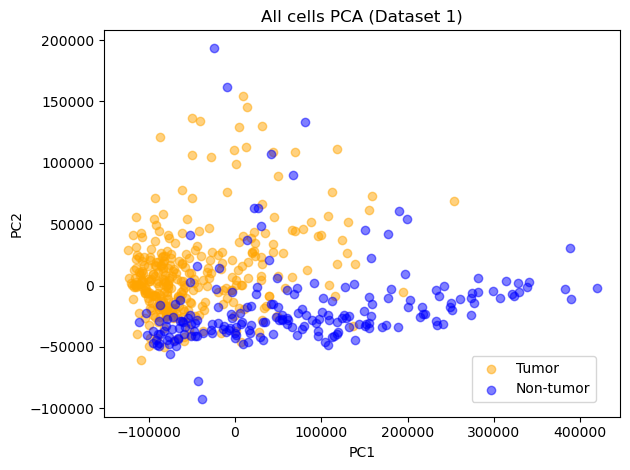

In [18]:
# PCA (simple dimensionality reduction)
pca_2d = PCA(n_components=2)
pca_2d.fit(cm_data)
all_sc_2d_pca = pca_2d.transform(cm_data)

fig, ax = plt.subplots()
ax.scatter(all_sc_2d_pca[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 0),0], 
           all_sc_2d_pca[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 0),1],
           c="orange", label="Tumor", alpha=0.5)
ax.scatter(all_sc_2d_pca[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 1),0], 
           all_sc_2d_pca[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 1),1],
           c="b", label="Non-tumor", alpha=0.5)
ax.set_title("All cells PCA (Dataset 1)")
ax.set_ylabel("PC2")
ax.set_xlabel("PC1")
fig.legend(bbox_to_anchor=(0.95,0.2), loc="center right")
#fig.legend()
plt.tight_layout()

print(f"Proportion of variance explained: {pca_2d.explained_variance_ratio_}")
print(f"Total proportion of variance explained by first two PCs: {sum(pca_2d.explained_variance_ratio_)}")
print(f"Number of cells: {len(all_sc_details)}")

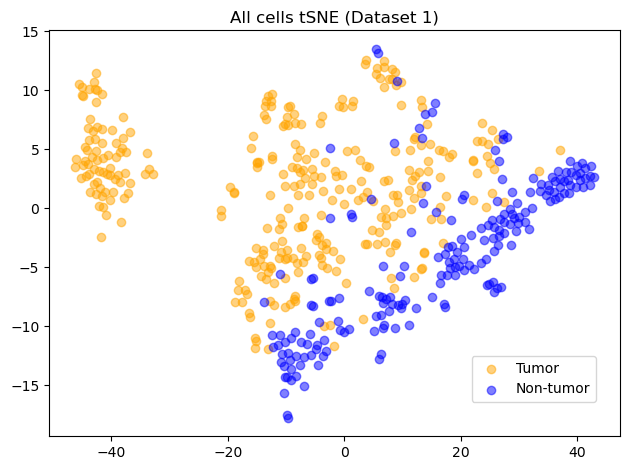

In [19]:
# tSNE
# NEED TO CHANGE TITLE OF GRAPH WHEN CHANGING THIS
tsne_2d = TSNE(n_components=2, perplexity=30, random_state=1000)
all_sc_2d_tsne = tsne_2d.fit_transform(cm_data)

fig, ax = plt.subplots()
ax.scatter(all_sc_2d_tsne[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 0),0], 
           all_sc_2d_tsne[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 0),1],
           c="orange", label="Tumor", alpha=0.5)
ax.scatter(all_sc_2d_tsne[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 1),0], 
           all_sc_2d_tsne[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 1),1],
           c="b", label="Non-tumor", alpha=0.5)
ax.set_title("All cells tSNE (Dataset 1)")
fig.legend(bbox_to_anchor=(0.95,0.2), loc="center right")
#fig.legend()
plt.tight_layout()

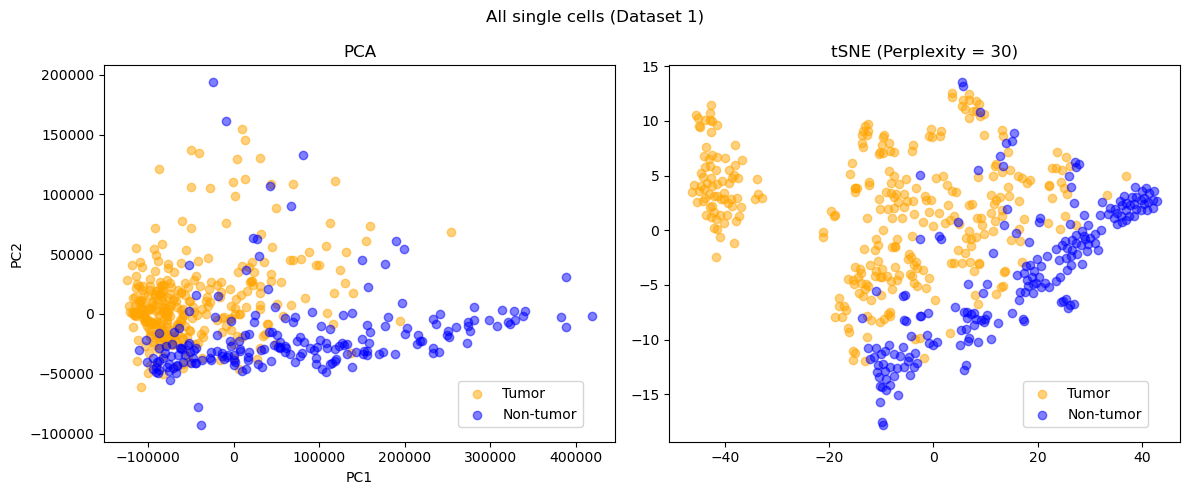

In [20]:
# relies on pca and tsne embeddings already being made above

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax[0].scatter(all_sc_2d_pca[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 0),0], 
           all_sc_2d_pca[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 0),1],
           c="orange", label="Tumor", alpha=0.5)
ax[0].scatter(all_sc_2d_pca[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 1),0], 
           all_sc_2d_pca[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 1),1],
           c="b", label="Non-tumor", alpha=0.5)
ax[0].set_title("PCA")
ax[0].set_ylabel("PC2")
ax[0].set_xlabel("PC1")
ax[0].legend(bbox_to_anchor=(0.95,0.1), loc="center right")

ax[1].scatter(all_sc_2d_tsne[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 0),0], 
           all_sc_2d_tsne[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 0),1],
           c="orange", label="Tumor", alpha=0.5)
ax[1].scatter(all_sc_2d_tsne[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 1),0], 
           all_sc_2d_tsne[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 1),1],
           c="b", label="Non-tumor", alpha=0.5)
ax[1].set_title("tSNE (Perplexity = 30)")
ax[1].legend(bbox_to_anchor=(0.95,0.1), loc="center right")

fig.suptitle("All single cells (Dataset 1)")
plt.tight_layout()
plt.show()

In [21]:
cm_data.max().sort_values()[-5:]


gene_id
ENSG00000211896.2    151342.29
ENSG00000211677.2    167560.23
ENSG00000242371.1    198151.76
ENSG00000211592.2    403470.52
SPIKE1                559906.6
dtype: object

In [22]:
print(f"Number of transcripts where all values are 0: {sum(cm_data.max() == 0)}")
print(f"Number of transcripts where all values are less than 1: {sum(cm_data.max() < 1)}")
print(f"Number of transcripts where all values are more than 0 and less than 1: {sum(cm_data.max() < 1) - sum(cm_data.max() == 0)}")

Number of transcripts where all values are 0: 22764
Number of transcripts where all values are less than 1: 24585
Number of transcripts where all values are more than 0 and less than 1: 1821


In [23]:
# repeat with log transformed data
#np.log10(+1)# + 1e-10
print(np.log10(10.0))
np.log10(cm_data.loc[:,"SPIKE1"].astype(float))

1.0


BC01_02    4.265156
BC01_03    4.292332
BC01_04    4.455210
BC01_05    4.494302
BC01_06    4.687391
             ...   
BC06_43    5.238504
BC06_58    5.616870
BC06_60    4.639243
BC06_61    5.551219
BC06_74    4.734430
Name: SPIKE1, Length: 515, dtype: float64

In [24]:
# EXCLUDE TRANSCRIPTS THAT ARE NEVER EXPRESSED IN THE 515 CELLS
cm_data.columns[cm_data.max() == 0]


Index(['ENSG00000000005.5', 'ENSG00000006059.3', 'ENSG00000006659.8',
       'ENSG00000006788.8', 'ENSG00000007001.8', 'ENSG00000008197.4',
       'ENSG00000008438.4', 'ENSG00000016602.8', 'ENSG00000021852.8',
       'ENSG00000029559.5',
       ...
       'ERCC-00158', 'ERCC-00160', 'ERCC-00162', 'ERCC-00163', 'ERCC-00164',
       'ERCC-00165', 'ERCC-00168', 'ERCC-00170', 'ERCC-00171', 'SPIKE3'],
      dtype='object', name='gene_id', length=22764)

In [25]:
cm_data_no_0_features = cm_data.copy()
all_cell_0_features = cm_data.columns[cm_data.max() == 0]
cm_data_no_0_features = cm_data_no_0_features.drop(columns=all_cell_0_features)
print(f"Remaining features = {len(cm_data_no_0_features.columns)}")

Remaining features = 35151


In [26]:
cm_data_no_0_features_log = cm_data_no_0_features.copy()
for col_name in cm_data_no_0_features.columns:
    cm_data_no_0_features_log[col_name] = np.log10(cm_data_no_0_features[col_name].astype(float) + 1)

In [27]:
cm_data_no_0_features_log.max().sort_values()[-5:]

gene_id
ENSG00000211896.2    5.179963
ENSG00000211677.2    5.224174
ENSG00000242371.1    5.297000
ENSG00000211592.2    5.605813
SPIKE1               5.748116
dtype: float64

In [28]:
cm_data_no_0_features_log.min().sort_values()[:5]

gene_id
ENSG00000273477.1     0.0
ENSG00000000419.8     0.0
ENSG00000000457.9     0.0
ENSG00000000460.12    0.0
ENSG00000000938.8     0.0
dtype: float64

In [29]:
pca_2d_no_0_log = PCA(n_components=2)
pca_2d_no_0_log.fit(cm_data_no_0_features_log)
all_sc_2d_pca_no_0_log = pca_2d_no_0_log.transform(cm_data_no_0_features_log)

tsne_2d_no_0_log = TSNE(n_components=2, perplexity=30, random_state=1000)
all_sc_2d_tsne_no_0_log = tsne_2d_no_0_log.fit_transform(cm_data_no_0_features_log)

In [30]:
print(f"Proportion of variance explained (PCA, unexpressed transcripts excluded, logTPM) = {pca_2d_no_0_log.explained_variance_ratio_}")
print(f"Total proportion of variance explained (PCA, unexpressed transcripts excluded, logTPM) = {sum(pca_2d_no_0_log.explained_variance_ratio_)}")


Proportion of variance explained (PCA, unexpressed transcripts excluded, logTPM) = [0.09487337 0.04496917]
Total proportion of variance explained (PCA, unexpressed transcripts excluded, logTPM) = 0.13984254767195395


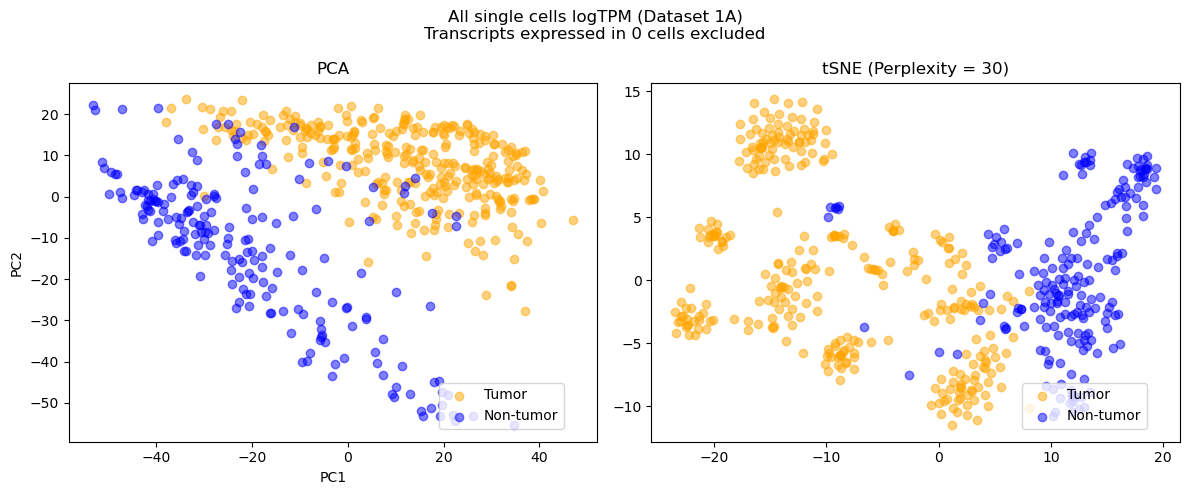

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax[0].scatter(all_sc_2d_pca_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 0),0], 
           all_sc_2d_pca_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 0),1],
           c="orange", label="Tumor", alpha=0.5)
ax[0].scatter(all_sc_2d_pca_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 1),0], 
           all_sc_2d_pca_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 1),1],
           c="b", label="Non-tumor", alpha=0.5)
ax[0].set_title("PCA")
ax[0].set_ylabel("PC2")
ax[0].set_xlabel("PC1")
ax[0].legend(bbox_to_anchor=(0.95,0.1), loc="center right")

ax[1].scatter(all_sc_2d_tsne_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 0),0], 
           all_sc_2d_tsne_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 0),1],
           c="orange", label="Tumor", alpha=0.5)
ax[1].scatter(all_sc_2d_tsne_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 1),0], 
           all_sc_2d_tsne_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 1),1],
           c="b", label="Non-tumor", alpha=0.5)
ax[1].set_title("tSNE (Perplexity = 30)")
ax[1].legend(bbox_to_anchor=(0.95,0.1), loc="center right")

fig.suptitle("All single cells logTPM (Dataset 1A)\nTranscripts expressed in 0 cells excluded")
plt.tight_layout()
plt.show()

In [32]:
# DO LATER OR SWITCH FROM HERE SO THAT ALL DETAILS ARE IN A DATAFRAME WITHOUT TPM
tumor_sc_details_only = tumor_sc_details["subtype"].copy()
tumor_sc_details_only

BC01_02    1
BC01_03    1
BC01_04    1
BC01_05    1
BC01_06    1
          ..
BC06_28    1
BC06_32    1
BC06_39    1
BC06_60    1
BC06_74    1
Name: subtype, Length: 317, dtype: object

Proportion of variance explained: [0.5308723  0.13865819]
Total proportion of variance explained: 0.6695304903322602


Text(0, 0.5, 'PC2')

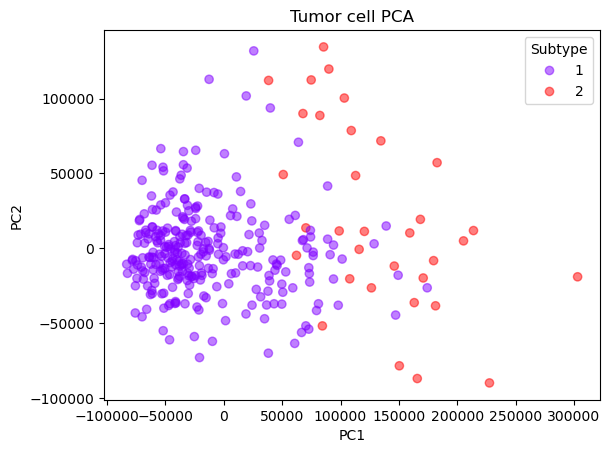

In [33]:
# PCA for tumor cells only
pca_2d_t = PCA(n_components=2)
pca_2d_t.fit(cm_tumour)
tumor_2d_pca = pca_2d_t.transform(cm_tumour)

# not a great proportion, predictably
# 2 clear clusters though
print(f"Proportion of variance explained: {pca_2d_t.explained_variance_ratio_}")
print(f"Total proportion of variance explained: {sum(pca_2d_t.explained_variance_ratio_)}")

# plot each subtype
# based on the order of the rows still being the same?

fig, ax = plt.subplots()
tumor_pca_scatter = ax.scatter(tumor_2d_pca[:,0], tumor_2d_pca[:,1], c=tumor_sc_details.loc[:,"subtype"], alpha=0.5, cmap="rainbow")
ax.legend(*tumor_pca_scatter.legend_elements(), title="Subtype")
ax.set_title("Tumor cell PCA")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

In [34]:
cm_tumour_no_0_log = cm_data_no_0_features_log.loc[final_sample_info_sc[final_sample_info_sc["index"] == "Tumor"]["sample"]]
cm_tumour_no_0_log

gene_id,ENSG00000000003.10,ENSG00000000419.8,ENSG00000000457.9,ENSG00000000460.12,ENSG00000000938.8,ENSG00000000971.11,ENSG00000001036.9,ENSG00000001084.6,ENSG00000001167.10,ENSG00000001460.13,...,ENSG00000273481.1,ENSG00000273484.1,ENSG00000273485.1,ENSG00000273486.1,ENSG00000273488.1,ENSG00000273489.1,ENSG00000273492.1,ERCC-00130,SPIKE1,SPIKE2
BC01_02,0.000000,1.713742,0.631444,0.000000,0.0,0.000000,1.026942,0.587711,0.247973,0.260071,...,0.0,0.0,0.0,0.0,0.0,0.843233,0.0,0.0,4.265180,2.730871
BC01_03,0.000000,2.084433,0.257679,1.158965,0.0,0.000000,1.572407,0.779596,0.318063,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4.292354,2.815757
BC01_04,0.000000,0.901458,1.969556,0.127105,0.0,0.000000,0.000000,2.037865,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4.455225,2.962568
BC01_05,0.000000,2.259713,0.871573,0.100371,0.0,0.000000,0.000000,0.521138,0.136721,0.423246,...,0.0,0.0,0.0,0.0,0.0,1.293363,0.0,0.0,4.494316,2.983342
BC01_06,0.000000,1.519697,1.783761,0.000000,0.0,0.123852,0.974051,1.729084,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4.687400,3.312490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BC06_28,0.839478,1.961658,1.864333,0.037426,0.0,0.000000,0.227887,0.000000,0.344392,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.734400,0.0,0.0,4.843183,3.433875
BC06_32,1.622628,1.999479,0.000000,0.946452,0.0,0.000000,1.407391,2.095448,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4.773951,3.450937
BC06_39,1.692759,2.480567,0.809560,0.000000,0.0,0.000000,0.184691,0.000000,0.579784,0.176091,...,0.0,0.0,0.0,0.0,0.0,1.100371,0.0,0.0,4.998088,3.487750
BC06_60,0.000000,2.545295,0.322219,0.000000,0.0,0.000000,0.599883,0.206826,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4.639253,3.223646


Proportion of variance explained: [0.06671006 0.03695129]
Total proportion of variance explained: 0.10366134848572656
Tumor cell PCA logTPM (Dataset 1A)
Transcripts expressed in 0 cells excluded


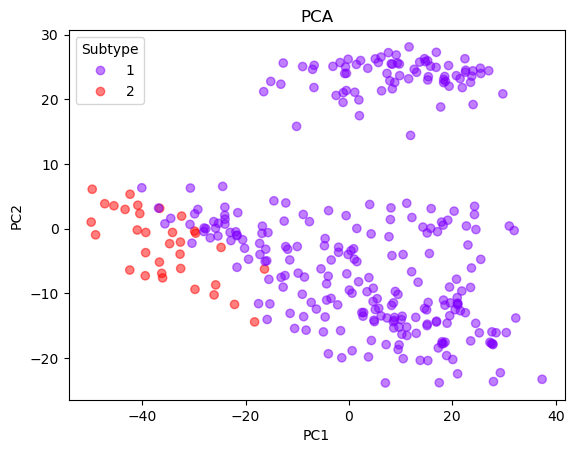

In [35]:
# PCA for tumor cells only (0s excluded, log transformed)
pca_2d_t_no_0_log = PCA(n_components=2)
pca_2d_t_no_0_log.fit(cm_tumour_no_0_log)
tumor_2d_pca_no_0_log = pca_2d_t_no_0_log.transform(cm_tumour_no_0_log)

# not a great proportion, predictably
# 2 clear clusters though
print(f"Proportion of variance explained: {pca_2d_t_no_0_log.explained_variance_ratio_}")
print(f"Total proportion of variance explained: {sum(pca_2d_t_no_0_log.explained_variance_ratio_)}")

# plot each subtype
# based on the order of the rows still being the same?

fig, ax = plt.subplots()
tumor_pca_scatter_no_0_log = ax.scatter(tumor_2d_pca_no_0_log[:,0], tumor_2d_pca_no_0_log[:,1], c=tumor_sc_details.loc[:,"subtype"], alpha=0.5, cmap="rainbow")
ax.legend(*tumor_pca_scatter_no_0_log.legend_elements(), title="Subtype")
#ax.set_title("Tumor cell PCA logTPM (Dataset 1A)\nTranscripts expressed in 0 cells excluded")
ax.set_title("PCA")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

print("Tumor cell PCA logTPM (Dataset 1A)\nTranscripts expressed in 0 cells excluded")

In [36]:
# tSNE for tumour cells (0 features excluded, logTPM)
tsne_2d_t_no_0_log = TSNE(n_components=2, perplexity=30, random_state=1000)
tumour_2d_tsne_no_0_log = tsne_2d.fit_transform(cm_tumour_no_0_log)

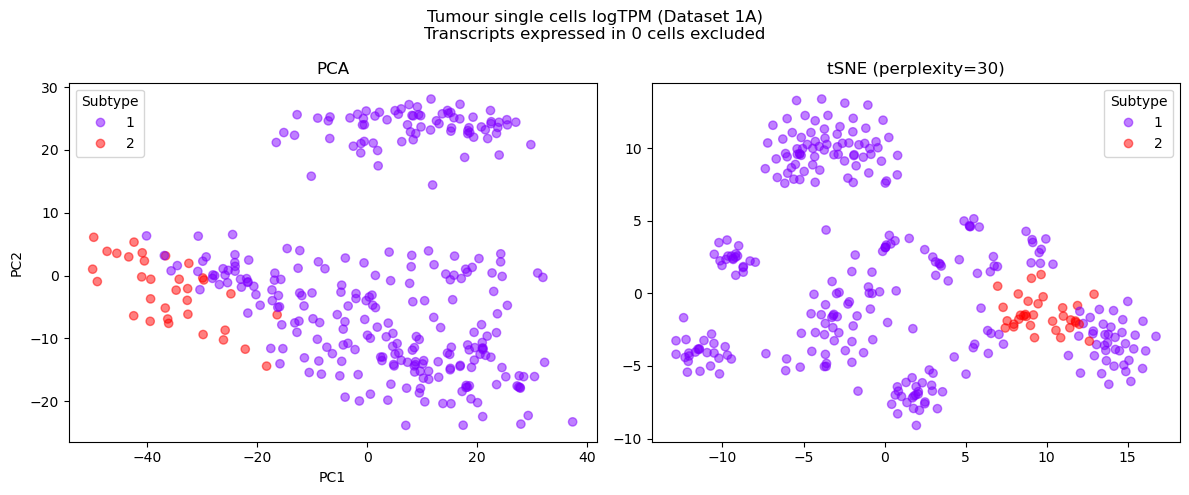

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

"""
ax[0].scatter(tumor_2d_pca_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 0),0], 
           tumor_2d_pca_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 0),1],
           c="orange", label="Tumor", alpha=0.5)
ax[0].scatter(tumor_2d_pca_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 1),0], 
           tumor_2d_pca_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 1),1],
           c="b", label="Non-tumor", alpha=0.5)
ax[0].set_title("PCA")
ax[0].set_ylabel("PC2")
ax[0].set_xlabel("PC1")
ax[0].legend(bbox_to_anchor=(0.95,0.1), loc="center right")
"""

tumor_pca_scatter_no_0_log = ax[0].scatter(tumor_2d_pca_no_0_log[:,0], tumor_2d_pca_no_0_log[:,1], c=tumor_sc_details.loc[:,"subtype"], alpha=0.5, cmap="rainbow")
ax[0].legend(*tumor_pca_scatter_no_0_log.legend_elements(), title="Subtype")
ax[0].set_title("PCA")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")

tumor_tsne_scatter_no_0_log = ax[1].scatter(tumour_2d_tsne_no_0_log[:,0], tumour_2d_tsne_no_0_log[:,1], c=tumor_sc_details.loc[:,"subtype"], alpha=0.5, cmap="rainbow")
ax[1].legend(*tumor_tsne_scatter_no_0_log.legend_elements(), title="Subtype")
ax[1].set_title("tSNE (perplexity=30)")

"""
ax[1].scatter(tumour_2d_tsne_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 0),0], 
           tumour_2d_tsne_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 0),1],
           c="orange", label="Tumor", alpha=0.5)
ax[1].scatter(tumour_2d_tsne_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 1),0], 
           tumour_2d_tsne_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 1),1],
           c="b", label="Non-tumor", alpha=0.5)
ax[1].set_title("tSNE (Perplexity = 30)")
ax[1].legend(bbox_to_anchor=(0.95,0.1), loc="center right")
"""


fig.suptitle("Tumour single cells logTPM (Dataset 1A)\nTranscripts expressed in 0 cells excluded")
plt.tight_layout()
plt.show()

In [38]:
#fig, ax = plt.subplots()
# tumour-non tumour
#tumor_pca_scatter_t_nt = ax.scatter(tumor_2d_pca[:,0], tumor_2d_pca[:,1], c=#, alpha=0.5, cmap="rainbow")
#ax.legend(*tumor_pca_scatter.legend_elements(), title="Subtype")
#ax.set_title("Tumor cell PCA")
#ax.set_xlabel("PC1")
#ax.set_ylabel("PC2")

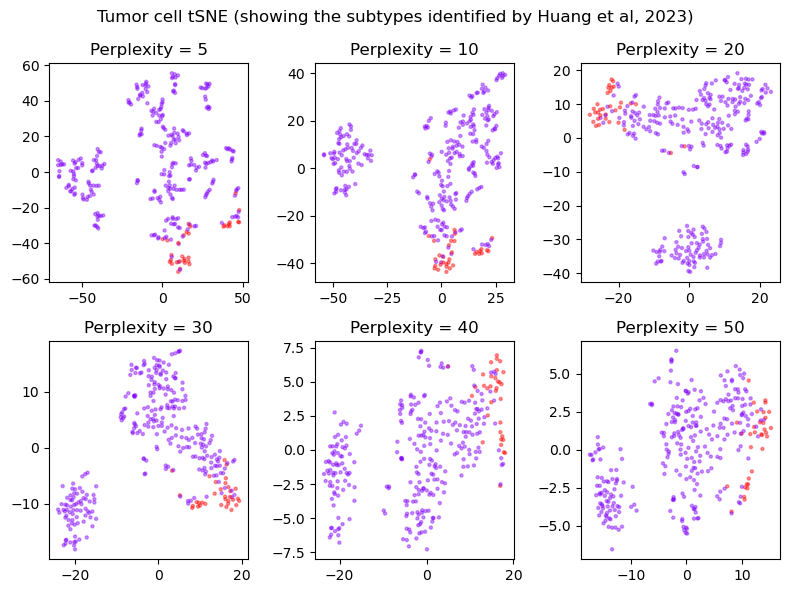

In [39]:
# comparing Huang subtypes to tSNE clusters
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,6))
perplexities = [5, 10, 20, 30, 40, 50]
for i in range(len(perplexities)):
    current_tsne = TSNE(perplexity=perplexities[i], random_state=1000)
    current_embedding = current_tsne.fit_transform(cm_tumour)
    axs[int(np.floor(i/3))][int(i%3)].scatter(current_embedding[:,0], current_embedding[:,1], c=tumor_sc_details["subtype"], s=5, alpha=0.4, cmap="rainbow")#
    axs[int(np.floor(i/3))][int(i%3)].set_title(f"Perplexity = {perplexities[i]}")
fig.suptitle("Tumor cell tSNE (showing the subtypes identified by Huang et al, 2023)")
plt.tight_layout()
plt.show()

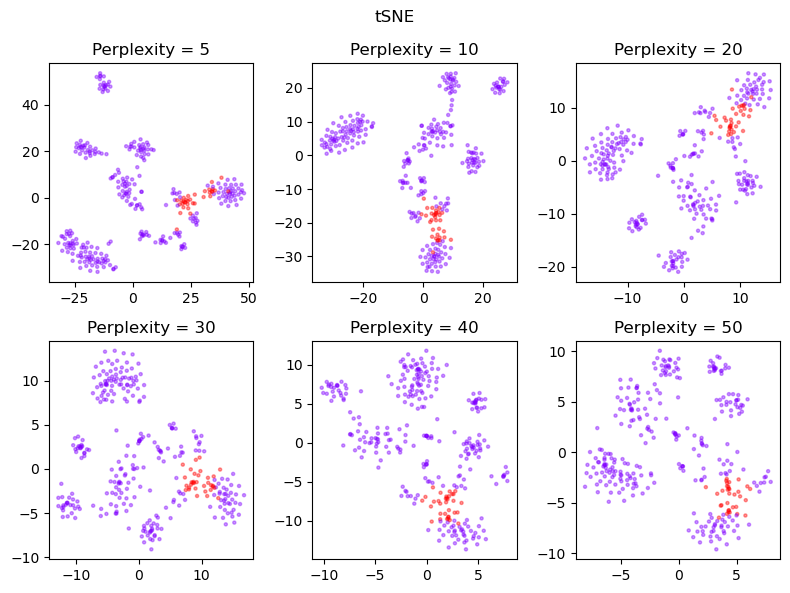

Tumor cell tSNE (Dataset 1A) (showing the subtypes identified by Huang et al, 2023)


In [40]:
# comparing Huang subtypes to tSNE clusters (1A)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,6))
perplexities = [5, 10, 20, 30, 40, 50]
for i in range(len(perplexities)):
    current_tsne = TSNE(perplexity=perplexities[i], random_state=1000)
    current_embedding = current_tsne.fit_transform(cm_tumour_no_0_log)
    axs[int(np.floor(i/3))][int(i%3)].scatter(current_embedding[:,0], current_embedding[:,1], c=tumor_sc_details["subtype"], s=5, alpha=0.4, cmap="rainbow")#
    axs[int(np.floor(i/3))][int(i%3)].set_title(f"Perplexity = {perplexities[i]}")
#fig.suptitle("Tumor cell tSNE (Dataset 1A) (showing the subtypes identified by Huang et al, 2023)")
fig.suptitle("tSNE")
plt.tight_layout()
plt.show()

print("Tumor cell tSNE (Dataset 1A) (showing the subtypes identified by Huang et al, 2023)")

In [41]:
tsne_p50 = TSNE(perplexity=50, random_state=1000)
tsne_p50_embedding = tsne_p50.fit_transform(cm_tumour)

In [42]:
tsne_p30_no_0_log= TSNE(perplexity=30, random_state=1000)
tsne_p30_embedding_no_0_log = tsne_p30_no_0_log.fit_transform(cm_tumour_no_0_log)

In [43]:
# PCA actual subtypes
# SAMPLES AND CORRESPONDING SUBTYPES FROM DATA PAPER
# BC03LN and BC07LN are lymph node metastases
sample_clinical_subtype_dict = {
    "BC01" : "luminal_A",
    "BC02" : "luminal_A",
    "BC03" : "luminal_B",
    "BC04" : "HER2",
    "BC05" : "HER2",
    "BC06" : "HER2",
    "BC07" : "TNBC",
    "BC08" : "TNBC",
    "BC09" : "TNBC",
    "BC10" : "TNBC",
    "BC11" : "TNBC",
    "BC03LN" : "luminal_B",
    "BC07LN" : "TNBC"
}

clinical_subtype_int_dict = {
    "luminal_A" : 1,
    "luminal_B" : 2,
    "HER2" : 3,
    "TNBC" : 4
}

In [44]:
# adding a column to details with which sample the cell is from
tumor_sc_details["sample"] = list(map(lambda element : element.split("_")[0], cm_tumour.index))

# adding a column to details with clinical subtype name
tumor_sc_details["clinical_subtype"] = list(map(lambda element : sample_clinical_subtype_dict[element.split("_")[0]], cm_tumour.index))

# adding a column to details with clinical subtype number
tumor_sc_details["clinical_subtype_no"] = list(map(lambda element : clinical_subtype_int_dict[element], tumor_sc_details["clinical_subtype"]))

In [45]:
# plot a given clustering on a given embedding
# use_preset_colours allows a consistent set of colours to be used across subplots
def plot_clustering_on_embedding(embedding, clusters, title, legend_title="Clusters",
                                 existing_plot=False, existing_ax=False, 
                                 use_preset_colours=False, preset_colours=False,
                                 cmap_function=plt.cm.nipy_spectral, legend_outside=False, 
                                 point_size=20, alpha=0.7, do_legend=True, return_legend=False):
    if existing_plot:
        ax = existing_ax
    else:
        fig, ax = plt.subplots()

    cluster_names = np.unique(clusters)

    # colours
    if use_preset_colours:
        colours = preset_colours
    else:
        colours = cmap_function(np.linspace(0, 1, len(cluster_names)))

    #print(cluster_names)
    for i in range(len(cluster_names)):
        # [?]
        ax.scatter(embedding[(clusters == cluster_names[i]), 0],
                   embedding[(clusters == cluster_names[i]), 1],
                   alpha = alpha, s=point_size, label=cluster_names[i],
                   color=colours[i]) # [?]


    #scatter = ax.scatter(embedding[:,0], embedding[:,1],
    #                    c=clusters, alpha=0.7, s=20, cmap=cmap)
    #ax.legend(*scatter.legend_elements(), title="Cluster")
    if do_legend and legend_outside:
        ax.legend(title=legend_title, bbox_to_anchor=(1.02,0.5), loc="center left")
    elif do_legend:
        ax.legend(title=legend_title)
    ax.set_title(title)

    plt.tight_layout()

    if return_legend:
        legend_handles, legend_labels = ax.get_legend_handles_labels()
        return legend_handles, legend_labels

In [46]:
col_name_format = "spectral_clustering_{value}"
spectral_clustering_col_names = []
for i in np.arange(2,6):
    current_spectral_clustering = SpectralClustering(n_clusters=i, assign_labels="cluster_qr", random_state=1000).fit(cm_tumour)
    tumor_sc_details[col_name_format.format(value=i)] = current_spectral_clustering.labels_
    spectral_clustering_col_names.append(col_name_format.format(value=i))

spectral_clustering_col_names

c:\Users\katie\miniconda3\envs\kf7029_env\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\katie\miniconda3\envs\kf7029_env\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\katie\miniconda3\envs\kf7029_env\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\katie\miniconda3\envs\kf7029_env\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


['spectral_clustering_2',
 'spectral_clustering_3',
 'spectral_clustering_4',
 'spectral_clustering_5']

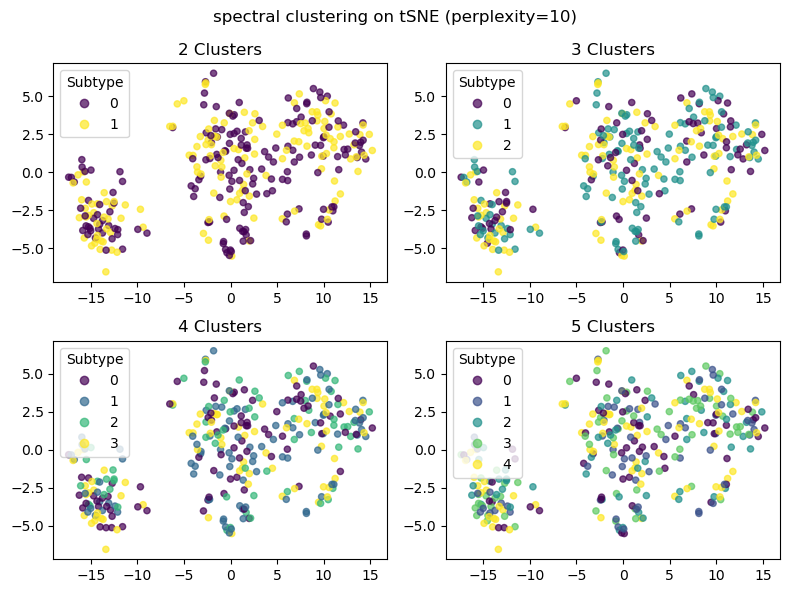

In [47]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
for i in range(len(spectral_clustering_col_names)):
    ax = axs[int(np.floor(i/2)), int(i%2)]
    tumor_pca_scatter = ax.scatter(tsne_p50_embedding[:,0], tsne_p50_embedding[:,1], c=tumor_sc_details.loc[:,spectral_clustering_col_names[i]], alpha=0.7, s=20)
    ax.legend(*tumor_pca_scatter.legend_elements(), title="Subtype")
    ax.set_title(f"{spectral_clustering_col_names[i][-1]} Clusters")

fig.suptitle("spectral clustering on tSNE (perplexity=10)")
plt.tight_layout()
plt.show()

In [48]:
# [!]
'''
col_name_format = "spectral_co_clustering_{value}"
spectral_co_clustering_col_names = []
spectral_co_clustering_dict = {}
# increased to 11 to get 2-10
# increased again to 2-13 (to include the number of different samples +1 for the isolated point)
for i in np.arange(2,14):
    current_spectral_co_clustering = SpectralCoclustering(n_clusters=i, random_state=1000).fit(cm_tumour)
    tumor_sc_details[col_name_format.format(value=i)] = current_spectral_co_clustering.row_labels_
    spectral_co_clustering_col_names.append(col_name_format.format(value=i))
    # ADDED TO BE ABLE TO ACCESS NUMBER OF CLUSTERS EASILY LATER
    spectral_co_clustering_dict[col_name_format.format(value=i)] = i

spectral_co_clustering_col_names
'''

'\ncol_name_format = "spectral_co_clustering_{value}"\nspectral_co_clustering_col_names = []\nspectral_co_clustering_dict = {}\n# increased to 11 to get 2-10\n# increased again to 2-13 (to include the number of different samples +1 for the isolated point)\nfor i in np.arange(2,14):\n    current_spectral_co_clustering = SpectralCoclustering(n_clusters=i, random_state=1000).fit(cm_tumour)\n    tumor_sc_details[col_name_format.format(value=i)] = current_spectral_co_clustering.row_labels_\n    spectral_co_clustering_col_names.append(col_name_format.format(value=i))\n    # ADDED TO BE ABLE TO ACCESS NUMBER OF CLUSTERS EASILY LATER\n    spectral_co_clustering_dict[col_name_format.format(value=i)] = i\n\nspectral_co_clustering_col_names\n'

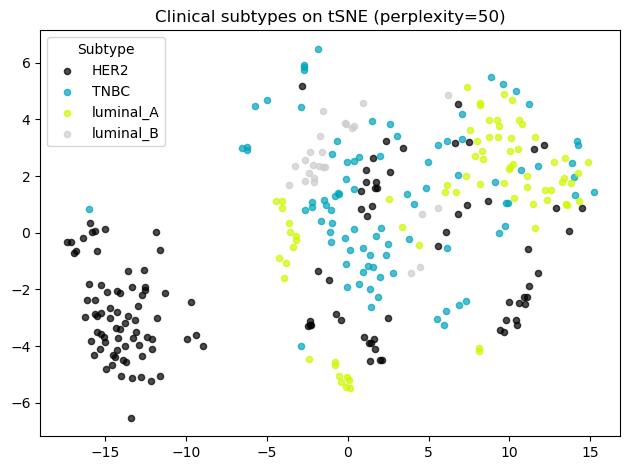

In [49]:
plot_clustering_on_embedding(tsne_p50_embedding, 
                             tumor_sc_details["clinical_subtype"], 
                             "Clinical subtypes on tSNE (perplexity=50)",
                             legend_title="Subtype")

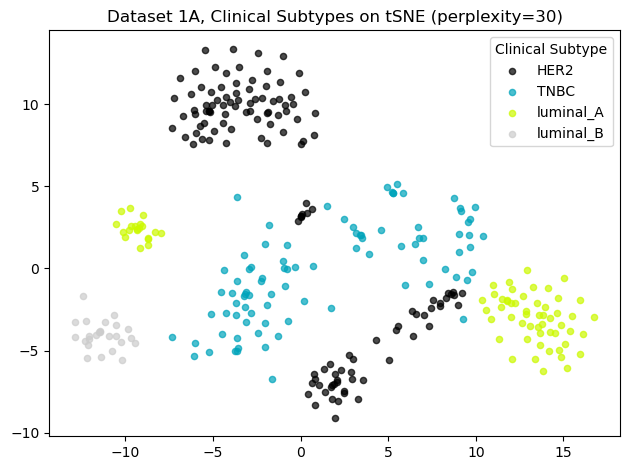

In [50]:
plot_clustering_on_embedding(tsne_p30_embedding_no_0_log, 
                             tumor_sc_details["clinical_subtype"], 
                             "Dataset 1A, Clinical Subtypes on tSNE (perplexity=30)",
                             legend_title="Clinical Subtype")

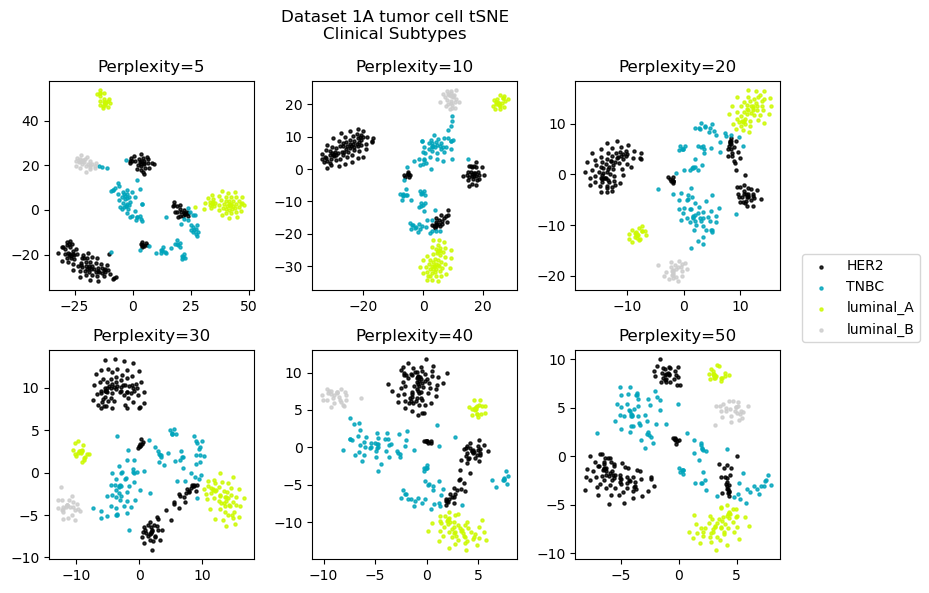

In [51]:
# comparing clinical subtypes to tSNE clusters (1A)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,6))
perplexities = [5, 10, 20, 30, 40, 50]
for i in range(len(perplexities)):
    current_tsne = TSNE(perplexity=perplexities[i], random_state=1000)
    current_embedding = current_tsne.fit_transform(cm_tumour_no_0_log)
    #axs[int(np.floor(i/3))][int(i%3)].scatter(current_embedding[:,0], current_embedding[:,1], c=tumor_sc_details["clinical_subtype"], s=5, alpha=0.4, cmap="rainbow")#
    #axs[int(np.floor(i/3))][int(i%3)].set_title(f"Perplexity = {perplexities[i]}")
    if i == 0:
        legend_handles, legend_labels = plot_clustering_on_embedding(current_embedding, tumor_sc_details["clinical_subtype"], f"Perplexity={perplexities[i]}", legend_title="Clinical Subtype", existing_plot=True, existing_ax=axs[int(np.floor(i/3))][int(i%3)], point_size=5, alpha=0.8, do_legend=False, return_legend=True)
    else:
        plot_clustering_on_embedding(current_embedding, tumor_sc_details["clinical_subtype"], f"Perplexity={perplexities[i]}", legend_title="Clinical Subtype", existing_plot=True, existing_ax=axs[int(np.floor(i/3))][int(i%3)], point_size=5, alpha=0.8, do_legend=False, return_legend=False)
fig.legend(legend_handles, legend_labels, bbox_to_anchor=(1.0,0.5), loc="center left")
fig.suptitle("Dataset 1A tumor cell tSNE\nClinical Subtypes")
plt.tight_layout()
plt.show()

#plot_clustering_on_embedding(current_embedding, tumor_sc_details["clinical_subtype"], "Dataset 1A tumor cell tSNE\nClinical Subtypes", legend_title="Clinical Subtype", existing_plot=True, existing_ax=axs[int(np.floor(i/3))][int(i%3)], point_size=20)

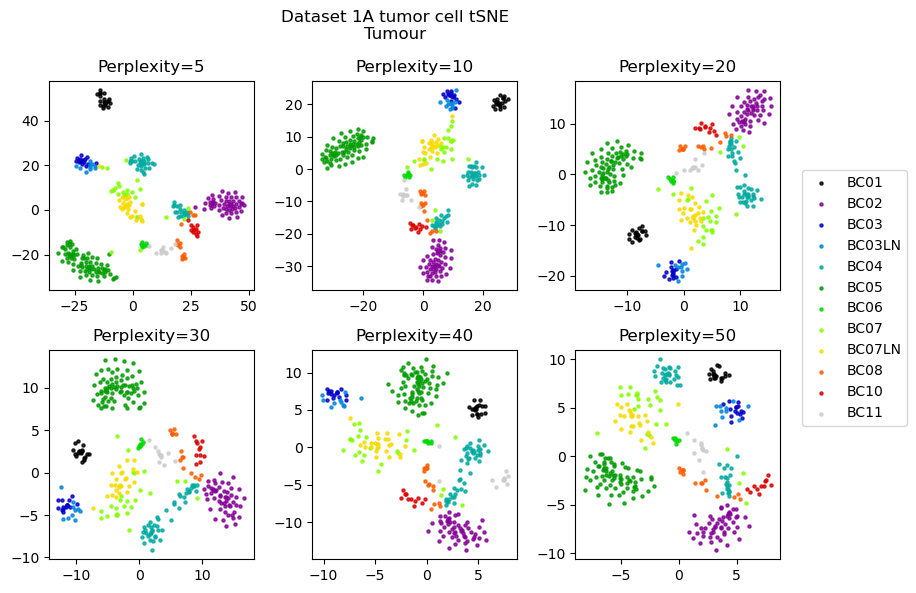

In [52]:
# comparing tumours to tSNE clusters (1A)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,6))
perplexities = [5, 10, 20, 30, 40, 50]
for i in range(len(perplexities)):
    current_tsne = TSNE(perplexity=perplexities[i], random_state=1000)
    current_embedding = current_tsne.fit_transform(cm_tumour_no_0_log)
    #axs[int(np.floor(i/3))][int(i%3)].scatter(current_embedding[:,0], current_embedding[:,1], c=tumor_sc_details["clinical_subtype"], s=5, alpha=0.4, cmap="rainbow")#
    #axs[int(np.floor(i/3))][int(i%3)].set_title(f"Perplexity = {perplexities[i]}")
    if i == 0:
        legend_handles, legend_labels = plot_clustering_on_embedding(current_embedding, tumor_sc_details["sample"], f"Perplexity={perplexities[i]}", legend_title="Clinical Subtype", existing_plot=True, existing_ax=axs[int(np.floor(i/3))][int(i%3)], point_size=5, alpha=0.8, do_legend=False, return_legend=True)
    else:
        plot_clustering_on_embedding(current_embedding, tumor_sc_details["sample"], f"Perplexity={perplexities[i]}", legend_title="Clinical Subtype", existing_plot=True, existing_ax=axs[int(np.floor(i/3))][int(i%3)], point_size=5, alpha=0.8, do_legend=False, return_legend=False)
fig.legend(legend_handles, legend_labels, bbox_to_anchor=(1.0,0.5), loc="center left")
fig.suptitle("Dataset 1A tumor cell tSNE\nTumour")
plt.tight_layout()
plt.show()

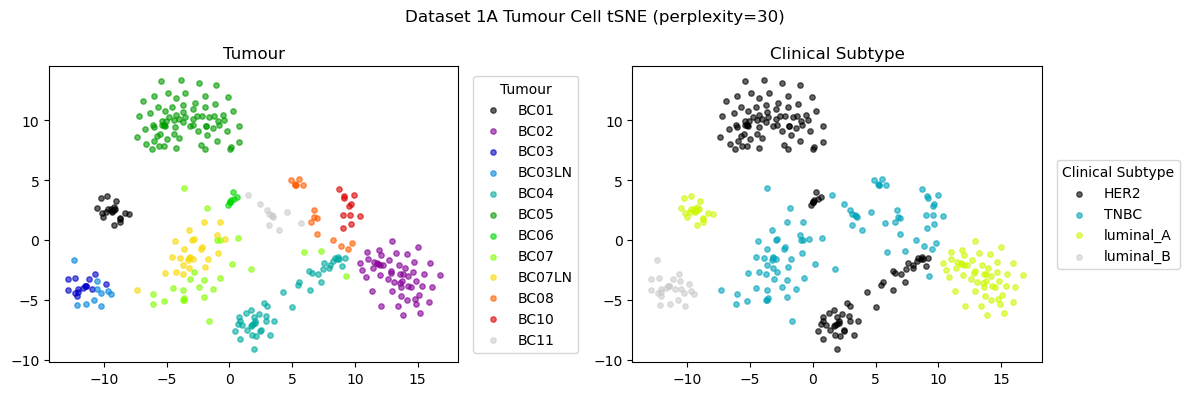

In [53]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

plot_clustering_on_embedding(tsne_p30_embedding_no_0_log, 
                             tumor_sc_details["sample"], 
                             "Tumour", 
                             legend_title="Tumour", 
                             existing_plot=True, 
                             existing_ax=axs[0], 
                             point_size=15, 
                             alpha=0.6, 
                             do_legend=True,
                             legend_outside=True)

plot_clustering_on_embedding(tsne_p30_embedding_no_0_log, 
                             tumor_sc_details["clinical_subtype"], 
                             "Clinical Subtype", 
                             legend_title="Clinical Subtype", 
                             existing_plot=True, 
                             existing_ax=axs[1], 
                             point_size=15, 
                             alpha=0.6, 
                             do_legend=True,
                             legend_outside=True)

fig.suptitle("Dataset 1A Tumour Cell tSNE (perplexity=30)")
plt.tight_layout()
plt.show()

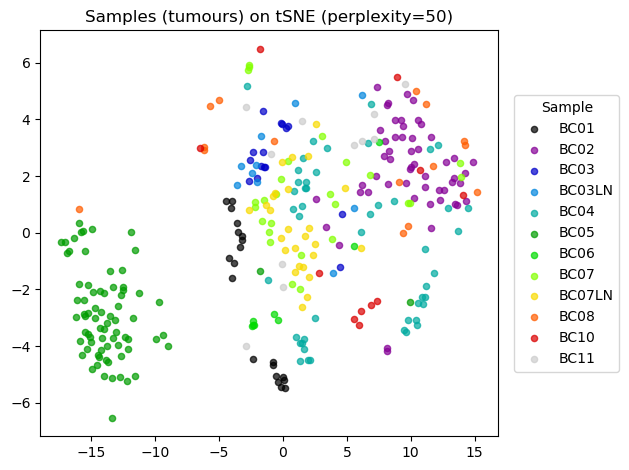

In [54]:
plot_clustering_on_embedding(tsne_p50_embedding, 
                             tumor_sc_details["sample"], 
                             "Samples (tumours) on tSNE (perplexity=50)",
                             legend_title="Sample",
                             legend_outside=True)

In [55]:
tumor_sc_details_no_bc05 = tumor_sc_details[tumor_sc_details["sample"] != "BC05"]
tumor_sc_details_no_bc05

gene_id,ENSG00000000003.10,ENSG00000000005.5,ENSG00000000419.8,ENSG00000000457.9,ENSG00000000460.12,ENSG00000000938.8,ENSG00000000971.11,ENSG00000001036.9,ENSG00000001084.6,ENSG00000001167.10,...,SPIKE2,SPIKE3,subtype,sample,clinical_subtype,clinical_subtype_no,spectral_clustering_2,spectral_clustering_3,spectral_clustering_4,spectral_clustering_5
BC01_02,0.0,0.0,50.73,3.28,0.0,0.0,0.0,9.64,2.87,0.77,...,537.11,0.0,1,BC01,luminal_A,1,1,2,3,4
BC01_03,0.0,0.0,120.46,0.81,13.42,0.0,0.0,36.36,5.02,1.08,...,653.27,0.0,1,BC01,luminal_A,1,0,0,2,2
BC01_04,0.0,0.0,6.97,92.23,0.34,0.0,0.0,0.0,108.11,0.0,...,916.42,0.0,1,BC01,luminal_A,1,1,2,3,4
BC01_05,0.0,0.0,180.85,6.44,0.26,0.0,0.0,0.0,2.32,0.37,...,961.37,0.0,1,BC01,luminal_A,1,1,2,3,0
BC01_06,0.0,0.0,32.09,59.78,0.0,0.0,0.33,8.42,52.59,0.0,...,2052.48,0.0,1,BC01,luminal_A,1,1,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BC06_28,5.91,0.0,90.55,72.17,0.09,0.0,0.0,0.69,0.0,1.21,...,2714.66,0.0,1,BC06,HER2,3,0,0,2,2
BC06_32,40.94,0.0,98.88,0.0,7.84,0.0,0.0,24.55,123.58,0.0,...,2823.47,0.0,1,BC06,HER2,3,0,0,1,2
BC06_39,48.29,0.0,301.39,5.45,0.0,0.0,0.0,0.53,0.0,2.8,...,3073.33,0.0,1,BC06,HER2,3,0,1,1,3
BC06_60,0.0,0.0,349.99,1.1,0.0,0.0,0.0,2.98,0.61,0.0,...,1672.58,0.0,1,BC06,HER2,3,0,1,1,0


In [56]:
cm_tumour_no_bc05 = cm_tumour[tumor_sc_details["sample"] != "BC05"]
cm_tumour_no_bc05

gene_id,ENSG00000000003.10,ENSG00000000005.5,ENSG00000000419.8,ENSG00000000457.9,ENSG00000000460.12,ENSG00000000938.8,ENSG00000000971.11,ENSG00000001036.9,ENSG00000001084.6,ENSG00000001167.10,...,ERCC-00162,ERCC-00163,ERCC-00164,ERCC-00165,ERCC-00168,ERCC-00170,ERCC-00171,SPIKE1,SPIKE2,SPIKE3
BC01_02,0.0,0.0,50.73,3.28,0.0,0.0,0.0,9.64,2.87,0.77,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18414.34,537.11,0.0
BC01_03,0.0,0.0,120.46,0.81,13.42,0.0,0.0,36.36,5.02,1.08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19603.44,653.27,0.0
BC01_04,0.0,0.0,6.97,92.23,0.34,0.0,0.0,0.0,108.11,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28523.94,916.42,0.0
BC01_05,0.0,0.0,180.85,6.44,0.26,0.0,0.0,0.0,2.32,0.37,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31210.57,961.37,0.0
BC01_06,0.0,0.0,32.09,59.78,0.0,0.0,0.33,8.42,52.59,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48684.49,2052.48,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BC06_28,5.91,0.0,90.55,72.17,0.09,0.0,0.0,0.69,0.0,1.21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69691.03,2714.66,0.0
BC06_32,40.94,0.0,98.88,0.0,7.84,0.0,0.0,24.55,123.58,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59421.55,2823.47,0.0
BC06_39,48.29,0.0,301.39,5.45,0.0,0.0,0.0,0.53,0.0,2.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99559.67,3073.33,0.0
BC06_60,0.0,0.0,349.99,1.1,0.0,0.0,0.0,2.98,0.61,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43575.58,1672.58,0.0


In [57]:
cm_tumour_no_bc05_no_0_log = cm_tumour_no_0_log[tumor_sc_details["sample"] != "BC05"]
cm_tumour_no_bc05_no_0_log

gene_id,ENSG00000000003.10,ENSG00000000419.8,ENSG00000000457.9,ENSG00000000460.12,ENSG00000000938.8,ENSG00000000971.11,ENSG00000001036.9,ENSG00000001084.6,ENSG00000001167.10,ENSG00000001460.13,...,ENSG00000273481.1,ENSG00000273484.1,ENSG00000273485.1,ENSG00000273486.1,ENSG00000273488.1,ENSG00000273489.1,ENSG00000273492.1,ERCC-00130,SPIKE1,SPIKE2
BC01_02,0.000000,1.713742,0.631444,0.000000,0.0,0.000000,1.026942,0.587711,0.247973,0.260071,...,0.0,0.0,0.0,0.0,0.0,0.843233,0.0,0.0,4.265180,2.730871
BC01_03,0.000000,2.084433,0.257679,1.158965,0.0,0.000000,1.572407,0.779596,0.318063,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4.292354,2.815757
BC01_04,0.000000,0.901458,1.969556,0.127105,0.0,0.000000,0.000000,2.037865,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4.455225,2.962568
BC01_05,0.000000,2.259713,0.871573,0.100371,0.0,0.000000,0.000000,0.521138,0.136721,0.423246,...,0.0,0.0,0.0,0.0,0.0,1.293363,0.0,0.0,4.494316,2.983342
BC01_06,0.000000,1.519697,1.783761,0.000000,0.0,0.123852,0.974051,1.729084,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4.687400,3.312490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BC06_28,0.839478,1.961658,1.864333,0.037426,0.0,0.000000,0.227887,0.000000,0.344392,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.734400,0.0,0.0,4.843183,3.433875
BC06_32,1.622628,1.999479,0.000000,0.946452,0.0,0.000000,1.407391,2.095448,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4.773951,3.450937
BC06_39,1.692759,2.480567,0.809560,0.000000,0.0,0.000000,0.184691,0.000000,0.579784,0.176091,...,0.0,0.0,0.0,0.0,0.0,1.100371,0.0,0.0,4.998088,3.487750
BC06_60,0.000000,2.545295,0.322219,0.000000,0.0,0.000000,0.599883,0.206826,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4.639253,3.223646


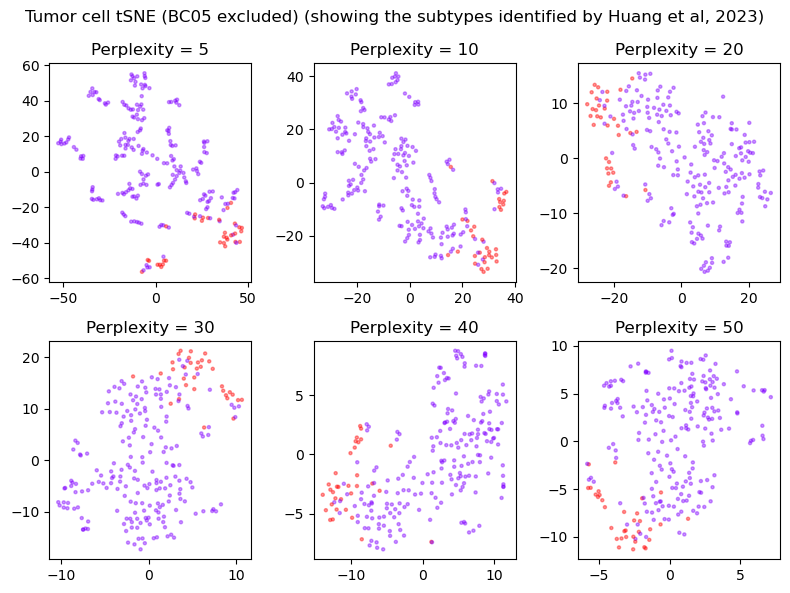

In [58]:
# comparing Huang subtypes to tSNE clusters (BC05 excluded)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,6))
perplexities = [5, 10, 20, 30, 40, 50]
for i in range(len(perplexities)):
    current_tsne = TSNE(perplexity=perplexities[i], random_state=1000)
    current_embedding = current_tsne.fit_transform(cm_tumour_no_bc05)
    axs[int(np.floor(i/3))][int(i%3)].scatter(current_embedding[:,0], current_embedding[:,1], c=tumor_sc_details_no_bc05["subtype"], s=5, alpha=0.4, cmap="rainbow")#
    axs[int(np.floor(i/3))][int(i%3)].set_title(f"Perplexity = {perplexities[i]}")
fig.suptitle("Tumor cell tSNE (BC05 excluded) (showing the subtypes identified by Huang et al, 2023)")
plt.tight_layout()
plt.show()

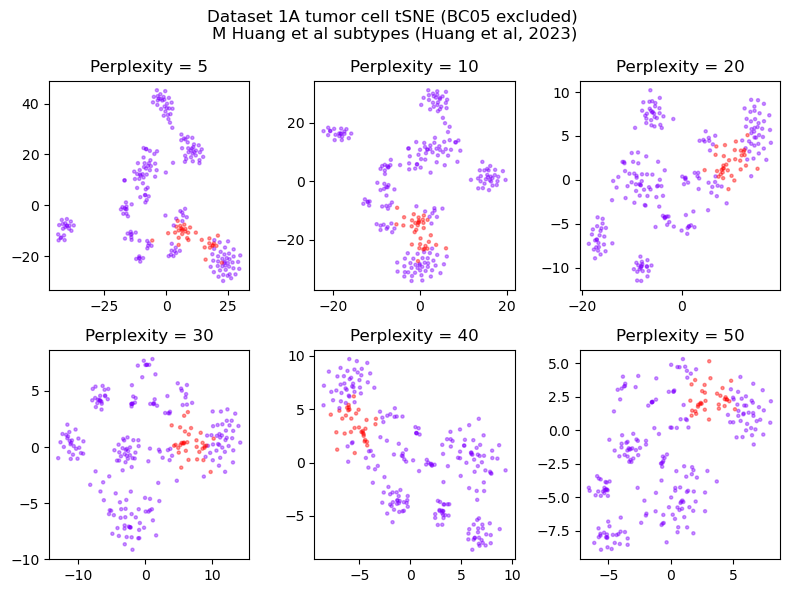

In [59]:
# comparing Huang subtypes to tSNE clusters (BC05 excluded) (1A)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,6))
perplexities = [5, 10, 20, 30, 40, 50]
for i in range(len(perplexities)):
    current_tsne = TSNE(perplexity=perplexities[i], random_state=1000)
    current_embedding = current_tsne.fit_transform(cm_tumour_no_bc05_no_0_log)
    axs[int(np.floor(i/3))][int(i%3)].scatter(current_embedding[:,0], current_embedding[:,1], c=tumor_sc_details_no_bc05["subtype"], s=5, alpha=0.4, cmap="rainbow")#
    axs[int(np.floor(i/3))][int(i%3)].set_title(f"Perplexity = {perplexities[i]}")
fig.suptitle("Dataset 1A tumor cell tSNE (BC05 excluded) \nM Huang et al subtypes (Huang et al, 2023)")
plt.tight_layout()
plt.show()

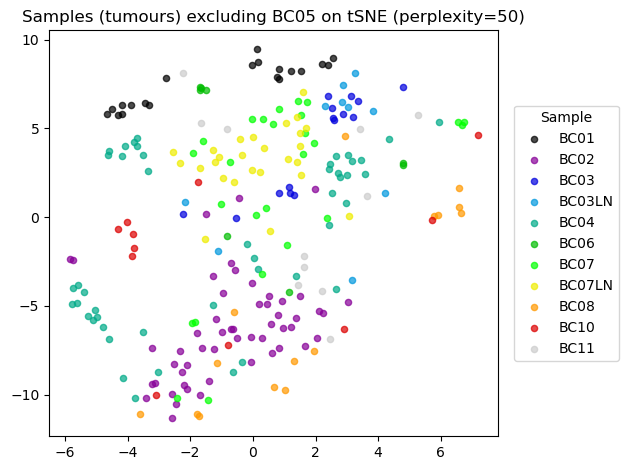

In [60]:
tsne_p50_excl_bc05 = TSNE(perplexity=50, random_state=1000)
tsne_p50_embedding_excl_bc05 = current_tsne.fit_transform(cm_tumour_no_bc05)

plot_clustering_on_embedding(tsne_p50_embedding_excl_bc05, 
                             tumor_sc_details_no_bc05["sample"], 
                             "Samples (tumours) excluding BC05 on tSNE (perplexity=50)",
                             legend_title="Sample",
                             legend_outside=True)

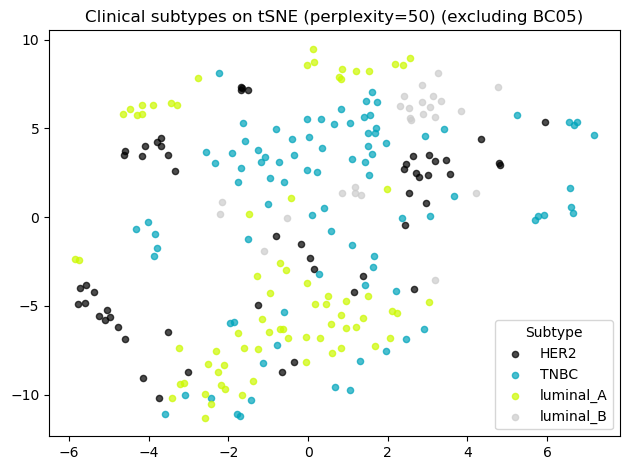

In [61]:
plot_clustering_on_embedding(tsne_p50_embedding_excl_bc05, 
                             tumor_sc_details_no_bc05["clinical_subtype"], 
                             "Clinical subtypes on tSNE (perplexity=50) (excluding BC05)",
                             legend_title="Subtype")

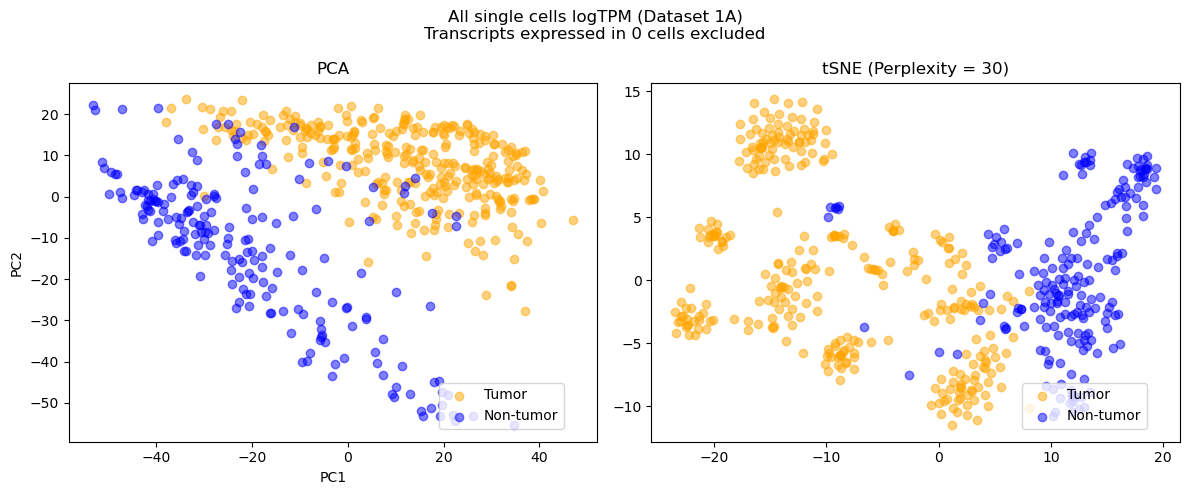

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax[0].scatter(all_sc_2d_pca_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 0),0], 
           all_sc_2d_pca_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 0),1],
           c="orange", label="Tumor", alpha=0.5)
ax[0].scatter(all_sc_2d_pca_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 1),0], 
           all_sc_2d_pca_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 1),1],
           c="b", label="Non-tumor", alpha=0.5)
ax[0].set_title("PCA")
ax[0].set_ylabel("PC2")
ax[0].set_xlabel("PC1")
ax[0].legend(bbox_to_anchor=(0.95,0.1), loc="center right")

ax[1].scatter(all_sc_2d_tsne_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 0),0], 
           all_sc_2d_tsne_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 0),1],
           c="orange", label="Tumor", alpha=0.5)
ax[1].scatter(all_sc_2d_tsne_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 1),0], 
           all_sc_2d_tsne_no_0_log[(all_sc_details.loc[:,"Tumor_NonTumor_Num"] == 1),1],
           c="b", label="Non-tumor", alpha=0.5)
ax[1].set_title("tSNE (Perplexity = 30)")
ax[1].legend(bbox_to_anchor=(0.95,0.1), loc="center right")

fig.suptitle("All single cells logTPM (Dataset 1A)\nTranscripts expressed in 0 cells excluded")
plt.tight_layout()
plt.show()

In [63]:
tumor_sc_details[tumor_sc_details["sample"] == "BC09"]["sample"]

Series([], Name: sample, dtype: object)

In [64]:

final_sample_info_details = final_sample_info.copy()

final_sample_info_details["patient"] = list(map(lambda element : element.split("_")[0], final_sample_info["sample"]))

final_sample_info_details["patient"]

final_sample_info_details[final_sample_info_details["patient"] == "BC09"]

# shows that there are no tumour single cells for patient BC09 (after quality control at least)
# (because the only value in "index" is "nonTumor")
pd.unique(final_sample_info_details[final_sample_info_details["patient"] == "BC09"]["index"])
 


array(['nonTumor'], dtype=object)